In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import json
import torchvision.models as models

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#data
data_dir = "flower_data"
train_dir =  data_dir + "/train"
valid_dir =  data_dir + "/valid"
#categories names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
len(cat_to_name)

102

In [4]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
data_transform = transforms.Compose([    
    #transforms.RandomRotation(50),
    transforms.Resize((224,224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean,std)
])

train_dataset = datasets.ImageFolder(train_dir,data_transform)
valid_dataset = datasets.ImageFolder(valid_dir,data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=True)

In [5]:
#Visualise some of the data
dataiterator = iter(train_loader)
imgs, labels = dataiterator.next()
imgs = imgs.numpy()
labels = labels.numpy()
print(imgs.shape)
print(labels.shape)

(64, 3, 224, 224)
(64,)


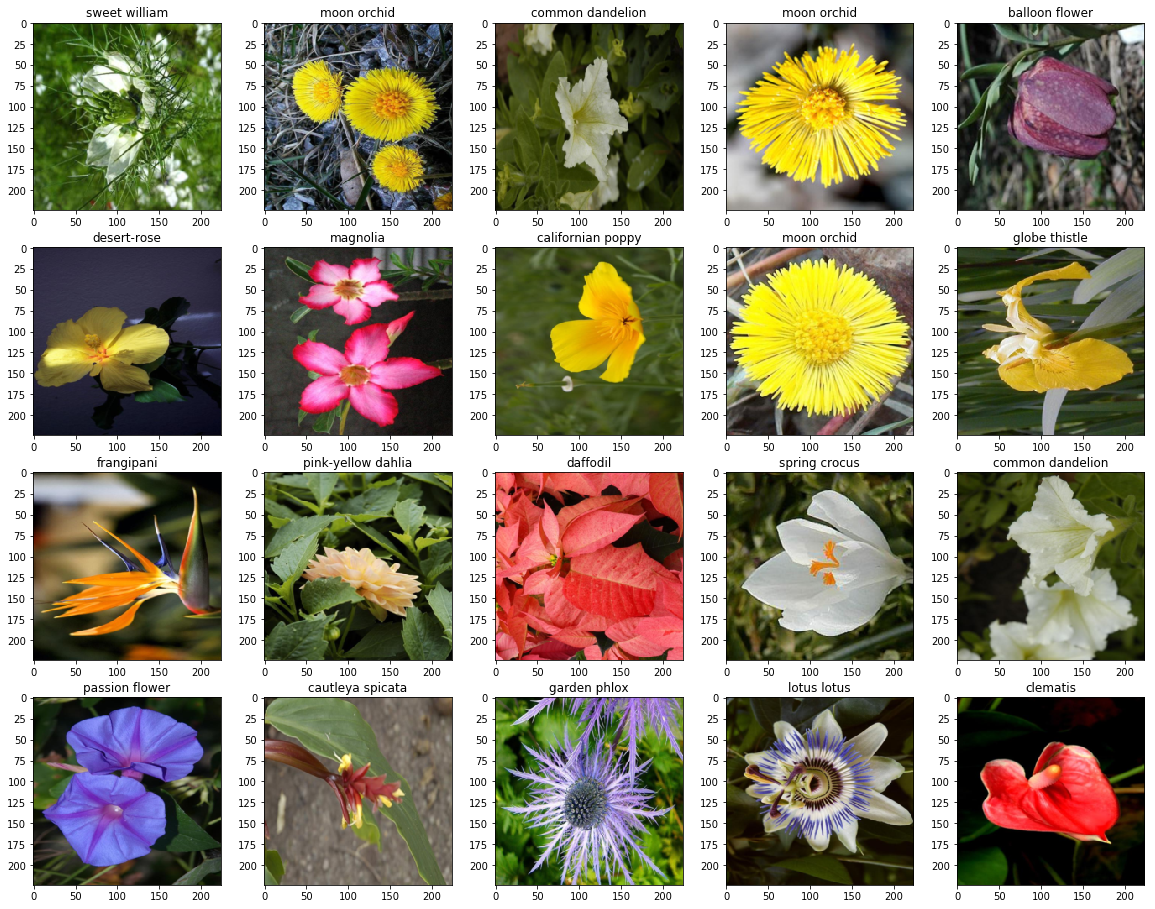

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
for indx in range(20):
    ax = fig.add_subplot(5,5,indx+1)
    plt.imshow(np.transpose((imgs[indx])))
    ax.set_title(cat_to_name[str(labels[indx]+1)])

In [7]:
model = models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
#model.fc = nn.Linear(512,102)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [8]:
model.classifier = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(9216,4096),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(4096,2048),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(2048,102)
                                )

In [9]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_features=2048,

In [ ]:
# specify loss function
criterion = nn.NLLLoss()
# specify optimizer
optimizer = optim.Adam(model.classifier.parameters(),lr=0.01)

In [ ]:
epochs = 5
valid_loss_min = np.inf
model.to(device)
for i in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    model.eval()
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        loss = criterion(predictions,labels)
        valid_loss += loss.item() * images.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    print('Epoch: {} \nTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i+1, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss